In [1]:
# using Pkg
# Pkg.activate(".")

Single Particle Spin $\tfrac{1}{2}$ system: Adiabatic Hamiltonian
====================================

Want to be able to represent a spin $\tfrac{1}{2}$ system so we can test the time evolution of different pulses. Our Hamiltonian can be controlled by a laser. A laser can be controlled by the intensity, frequency, and phase. While not exactly the same, these can be mapped to three parameters in our Hamiltonian:
$$
\text{intensity} \mapsto \Omega(t) \\
\text{frequency} \mapsto \Delta(t) \\
\text{phase} \mapsto \phi(t) 
$$
which appear in the Hamiltonian as follows:
$$
\hat{H} = \frac{-\Delta(t)}{2}\hat{1} 
    - \frac{-\Delta(t)}{2}\hat{\sigma}_z 
    + \frac{\Omega(t)}{2}
        (
            \cos{\phi(t)}\hat{\sigma}_x +
            \sin{\phi(t)}\hat{\sigma}_y
        )
    = \frac{-\Delta(t)}{2}\hat{1} + \frac{1}{2}\tilde{\vec{\Omega}}(t) \cdot \hat{\vec{\sigma}}
$$
for now we will take $\phi$ to be zero.

In [2]:
using QuantumOptics
using LinearAlgebra


computational = SpinBasis(1//2)

I = identityoperator(computational)
σx = sigmax(computational)
σy = sigmay(computational)
σz = sigmaz(computational)
σ_vec = [σx, σy, σz]

"""
Move the rabi vector from π to π+h over the time T.
"""
function evolve_for_T_to_h(T::Real, h::Real)
    Ω_eff_mag(t) = 1.0
    b = π
    m = 2*h/T
    # θ(t) = t < T/2 ? m*t+b : -m*(t-T)+b # linear up then down
    θ(t) = -(m^2/h)*t^2+2*m*t+b  # quadratic

    Δ(t) = cos(θ(t))*Ω_eff_mag(t)
    Ω(t) = -tan(θ(t))*Δ(t)
    Ω_vec(t) = [Ω(t), 0.0, -Δ(t)]


    H(t, ignored) = Ω(t)*σx/2 - Δ(t)*I/2 - Δ(t)*σz/2 

    tspan = [0.0:0.01:T;] 
    tout, psi_t = timeevolution.schroedinger_dynamic(tspan, spindown(computational), H)
    return tout, psi_t, H
end


evolve_for_T_to_h

Here is a quick example of the Bloch sphere trajectory made by a simple Hamiltonian evolution:

Vector{Ket{SpinBasis{1//2, Int64}, Vector{ComplexF64}}}
Ket(dim=2)
  basis: Spin(1/2)
 0.0 + 0.0im
 1.0 + 0.0im
---->
Ket(dim=2)
  basis: Spin(1/2)
  0.0011940521086733 - 0.00293267569541501im
 -0.5979095197882905 + 0.8015355938070922im


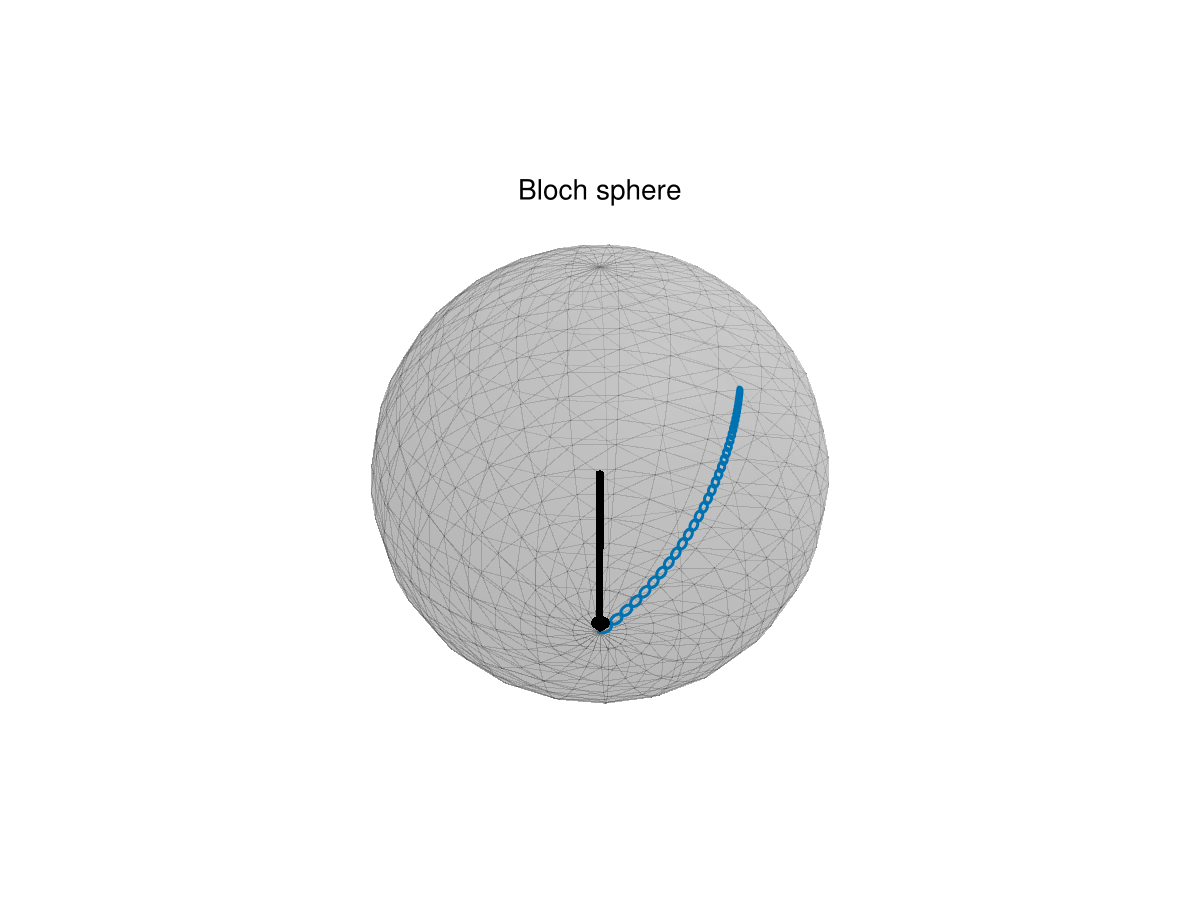

CairoMakie.Screen{IMAGE}


In [3]:
include("./Plotting.jl")
include("./Utils.jl")
using CairoMakie

tout, psi_t = evolve_for_T_to_h(500, pi/2)
psi_t[end]
println(typeof(psi_t))
println(psi_t[1],"\n---->\n", psi_t[end])
# println((statevectorToBlochvector.(psi_t)))
fig = Figure()
bloch = bloch_plot!(fig[1,1], tout, psi_t)
text!(bloch, 0, 0, 1.25, text="Bloch sphere", align=(0.5,0))
display(fig)


The way we defined the function `evolve_for_T_to_h` will move the Rabi vector at a rate quadratic with time up to the equator then back down. 

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


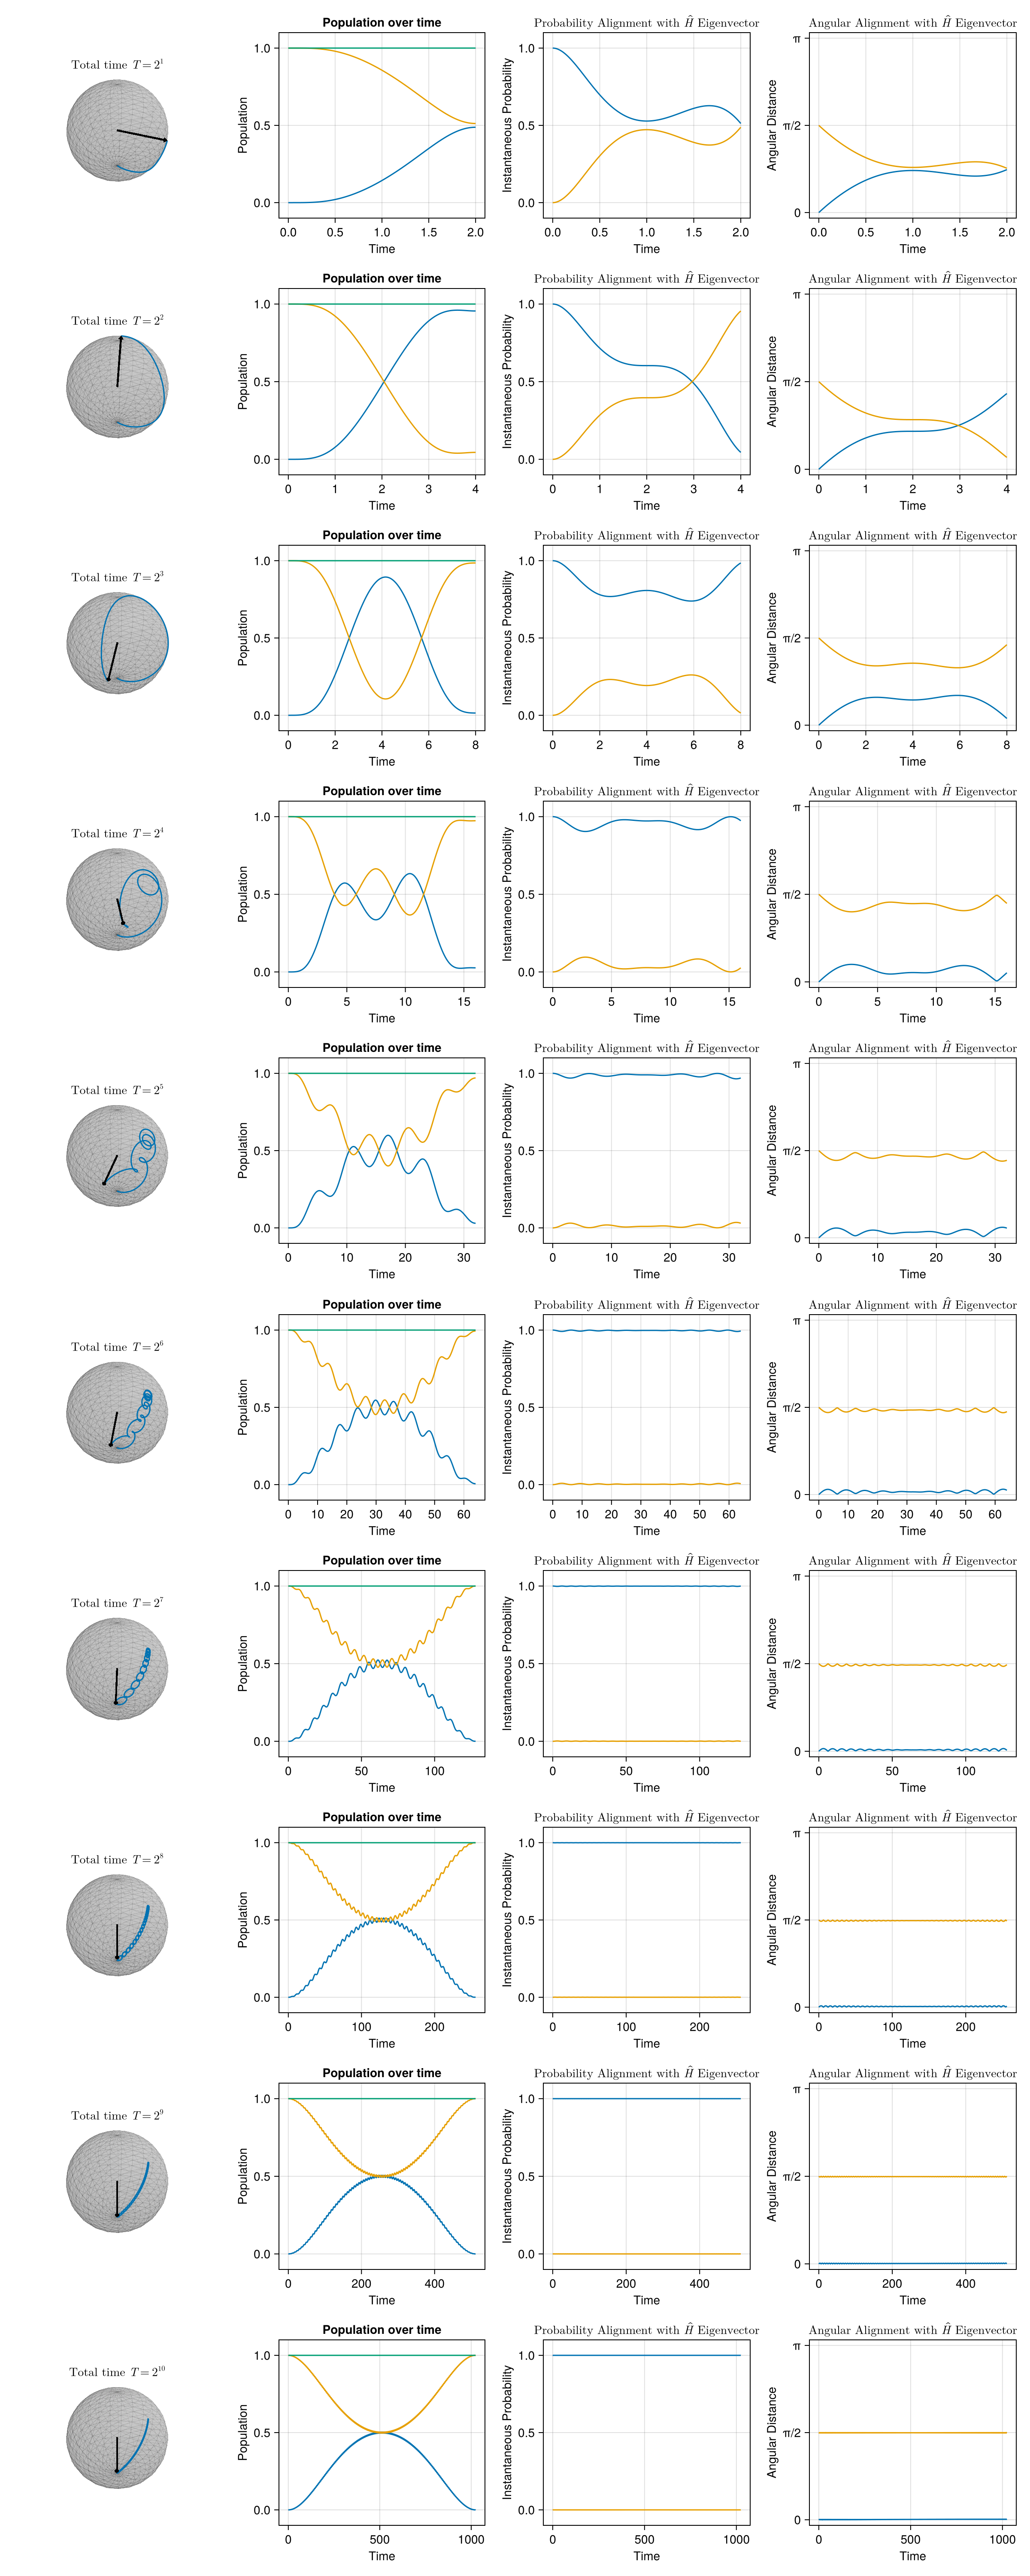

CairoMakie.Screen{IMAGE}


In [4]:
include("./Plotting.jl")
include("./Utils.jl")
using CairoMakie

fig = Figure(size = (1200, 3000))
for (i,T) in enumerate(2 .^ (1:10))
    tout, psi_t, H = evolve_for_T_to_h(T, π/2)
    
    bloch_plot!(fig[i, 1], tout, psi_t, title=L"Total time $T=2^{%$(i)}$")
    pop_ax = population_plot!(fig[i, 2], tout, psi_t)
    alignment_plot!(fig[i, 3], tout, psi_t, (t -> H(t, nothing)))
    alignment_angle_plot!(fig[i, 4], tout, psi_t, (t -> H(t, nothing)))
    println("Iteration $i")
end
display(fig)

For building intuition and visual (*soft*) verification we can animate the motion on the Bloch sphere.

In [5]:
include("./Plotting.jl")

# not adiabatic
tout, psi_t, H = evolve_for_T_to_h(2^7, π/2)
filename = "./graphics/not-adiabatic.gif"
save_bloch_animation(tout, psi_t, 2, 45, filename, title="Not Adiabatic")

display("text/html", """
<img src="$filename" width=600>
""")

# more adiabatic
tout2, psi_t2, H2 = evolve_for_T_to_h(2^9, π/2)
filename2 = "./graphics/adiabatic.gif"
save_bloch_animation(tout2, psi_t2, 8, 24, filename2, title="Almost Adiabatic")

display("text/html", """
<img src="./graphics/adiabatic.gif" width=600>
""")